### Surface variables (FSLE, EKE, OW)

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import math
import gsw
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches

%matplotlib inline

plt.rcParams['font.size'] = '14'

In [7]:
import imp
import src.importData as imports
import src.calc as calc
import src.interpolation as interp
import src.plots as plots
import src.stats as stats
import src.concat as ct
import src.settings as settings

In [11]:
my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'figures', 'chapter1_manuscript', 'revision_figures')

In [71]:
# Import float data 
floatids = [8489, 8490, 8492, 8493]
ema = imports.importFloatData(floatids)

In [16]:
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')

# Sea surface height (SSH)
file = 'CMEMS.nc'
alt_cmems = imports.importNetCDF(datadir, 'cmems_mr.nc', datatype ='altimetry')

# Okubo-Weiss
ow = imports.importNetCDF(datadir, 'okubo_weiss.nc', datatype ='altimetry').okubo_weiss

# SSH gradient
ssh_gradient = calc.sshGrad(alt_cmems.adt)

# geostrophic velocities
ugos, vgos = alt_cmems.ugos, alt_cmems.vgos
geos_speed =  calc.speed(ugos, vgos)

# FLSE
ds = imports.importNetCDF(datadir, 'FSLE.nc')
fsle = ds.rename({'lat':'latitude', 'lon':'longitude'}).fsle_max

# Sea surface temperature (SST)
sst_ds_0_02 = imports.importNetCDF(datadir, 'IMOS_aggregation_20220923T013201Z.nc', datatype ='sst')
sst_ds = sst_ds_0_02.rename({'lat':'latitude', 'lon':'longitude'})
sst = sst_ds.sea_surface_temperature
sst_deg = sst - 273.15

# SST gradient
sst_gradient = calc.sshGrad(sst_deg)

# bathymetry
bathymetry =  imports.importNetCDF(datadir, 'bathy.nc', datatype ='bathy')
bathymetry['depth'] = bathymetry.elevation*-1
new_bathy = bathymetry.coarsen(lon=10).mean().coarsen(lat=10).mean()

In [26]:
# half-inertial pair averaged dataset
rot_vels = {}

datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats')
                       
for floatid in floatids:
    #rotated velocities
    file = os.path.join(datadir, 'rotated_velocity', 'by_profile', 'rot_vel_%s.nc' %floatid)
    rot_vels[floatid] = xr.open_dataset(file)
    
ds = imports.sub_inertial_ds(ema, floatids, datadir, xdim = 'profile')
ds_dist = imports.sub_inertial_ds(ema, floatids, datadir, xdim = 'distance', rot_vels = rot_vels)

In [27]:
# # half-inertial pair averaged dataset
# datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats')
# ds = imports.sub_inertial_ds(ema, floatids, datadir, xdim = 'distance')

In [44]:
floatid = 8493
float_num = ema[floatid]
dist = calc.cum_dist(float_num.longitude, float_num.latitude)
rs = calc.findRSperiod(float_num)

In [45]:
start = float_num.time.values[0] # - np.timedelta64(7,'D')
# end = start + np.timedelta64(7*8,'D')
end = float_num.time[rs].values[-1] # + np.timedelta64(7,'D')
start_time = str(start.astype('M8[D]'))
end_time = str(end.astype('M8[D]'))

lonmin, lonmax = 145, 168
latmin, latmax = -60, -50
# lonmin, lonmax = 148, 162
# latmin, latmax = -58, -50

In [46]:
msl = alt_cmems.adt.sel(longitude = slice(lonmin, lonmax), time = slice(start_time, end_time)).mean(dim = 'time')
# ssh_levels = np.arange(-0.7, 0.4, 0.1)
ssh_levels = [-0.8, -0.7, -0.6, -0.5, -0.3, -0.2, -0.1, 0, 0.1]

In [47]:
imp.reload(calc)
ssh_std = calc.ssh_std(alt_cmems, float_num, start_time = start, end_time = end, interp_to_flt = False)

mean ADT between 2018-10-21 and 2018-12-05


In [49]:
imp.reload(calc)
EKE = calc.calcEKE(float_num, floatid, alt_ds = alt_cmems, altimetry = True, interp_to_flt = False)
mean_EKE = EKE.sel(time = slice(start_time, end_time)).mean(dim = 'time')

mean u and v between 2016-10-21 and 2019-10-21


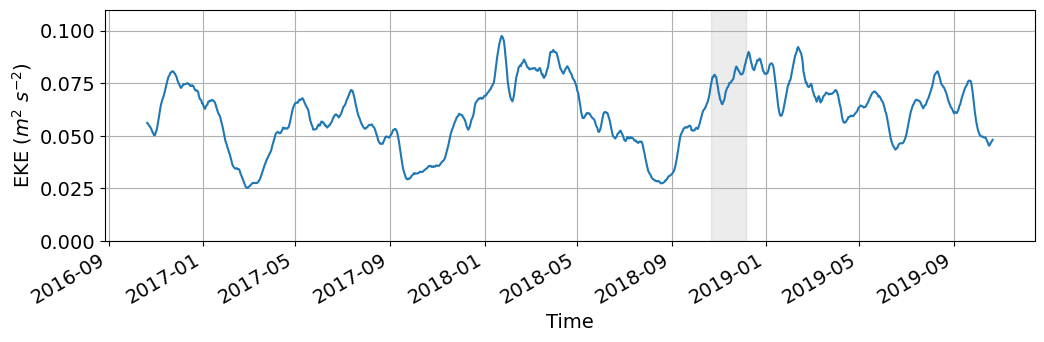

In [50]:
# temporal variability of EKE averaged over the region in the red box
fig, ax = plt.subplots(figsize = (12,3))
EKE.sel(longitude = slice(148, 156), 
        latitude = slice(-57, -51)).mean(
                    dim = 'latitude').mean(
                    dim = 'longitude').sel(time = slice('2016-10-21', '2019-10-21')).plot()

plt.ylim(0,0.11)
ax.axvspan(xmin =start_time, xmax = end_time, color = 'grey', alpha = 0.15)
plt.ylabel('EKE ($m^{2}$ $s^{-2}$)')
plt.grid()

start: 2018-10-21
end: 2018-12-05


Text(0.5, 1.0, '2018-10-21 $-$ 2018-12-05')

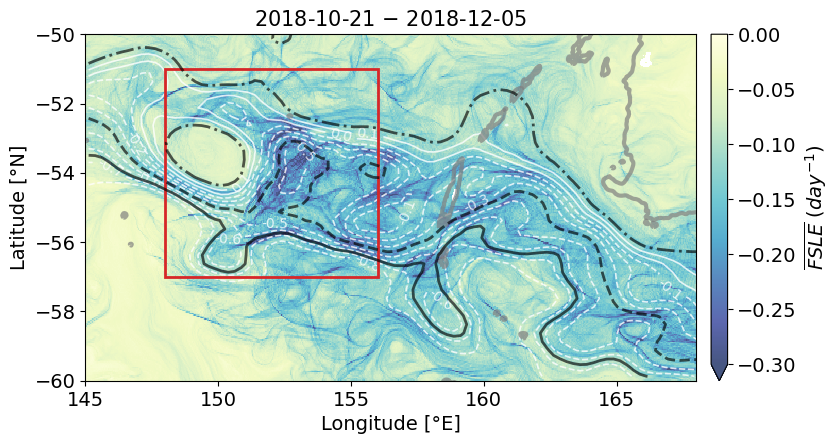

In [51]:
d_levels = [1500] 

print(f'start: {start_time}')
print(f'end: {end_time}')

fig, ax = plt.subplots(figsize = (9.5, 4.5))

m_fsle = fsle.sel(time = slice(start_time, end_time)).mean(dim = 'time').sel(latitude = slice(latmin, latmax),longitude = slice(lonmin, lonmax))
m_fsle.plot(cmap = 'YlGnBu_r', vmin = -0.3, vmax = 0, alpha = 0.75, 
            cbar_kwargs = dict(label = '$\overline{FSLE}$ $(day^{-1})$', pad = 0.02))

msl = alt_cmems.adt.sel(time = slice(start_time, end_time)).mean(dim = 'time')

levels = np.arange(-0.8,0.3,0.1)
CS = msl.plot.contour(colors = 'white', linewidths = 1.2, levels = ssh_levels, alpha = 0.8, zorder = 1)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.1f')

# PF
msl.plot.contour(levels = np.arange(-0.65, -0.64, 0.05), linestyles = '-',
                                         colors = 'k', alpha = 0.65, linewidths = 2, zorder = 5)

# SAF-S
msl.plot.contour(levels = np.arange(-0.4, -0.39, 0.05), linestyles = '--',
                                         colors = 'k', alpha = 0.65, linewidths = 2, zorder = 5) 

# SAF-N
msl.plot.contour(levels = np.arange(0.21, 0.22, 0.05), linestyles = '-.',
                                         colors = 'k', alpha = 0.65, linewidths = 2, zorder = 5) 


CS = new_bathy.depth.plot.contour(colors = 'grey', linewidths = 3, levels = d_levels, alpha = 0.7)

blonmin, blonmax = 148, 156
blatmin, blatmax = -57, -51

rect = mpatches.Rectangle((blonmin,blatmin),blonmax-blonmin,blatmax-blatmin, edgecolor='tab:red', facecolor="none", linewidth = 2, 
                         zorder = 4)

plt.gca().add_patch(rect)

ax.set_xlabel(u'Longitude [\N{DEGREE SIGN}E]')
ax.set_ylabel(u'Latitude [\N{DEGREE SIGN}N]')
plt.title(f'{start_time} $-$ {end_time}', fontsize = 15)


In [44]:
# settings.save_figure(fig, my_path, 'FSLE.png', dpi = 600, pad = None)

Text(0.5, 1.0, '2018-10-21 $-$ 2018-12-05')

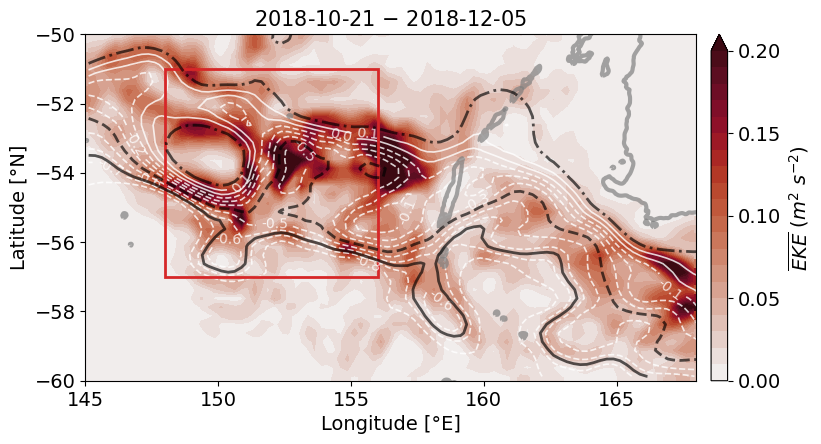

In [52]:
fig, ax = plt.subplots(figsize = (9.5, 4.5))
m_EKE = mean_EKE.sel(longitude = slice(lonmin, lonmax))
m_EKE.plot(cmap = cmocean.cm.amp, levels = np.arange(0, 0.21, 0.01), add_colorbar = False)      
m_EKE.plot.contourf(cmap = cmocean.cm.amp, levels = np.arange(0, 0.21, 0.01),
                            cbar_kwargs = dict(label = '$\overline{EKE}$ ($m^{2}$ $s^{-2}$)', 
                                               ticks = np.arange(0, 0.25,0.05), pad = 0.02))

CS = msl.plot.contour(colors = 'w', linewidths = 1.2, alpha = 0.8, levels = ssh_levels, zorder = 1)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.1f')

# PF
msl.plot.contour(levels = np.arange(-0.65, -0.64, 0.05), linestyles = '-',
                                         colors = 'k', alpha = 0.65, linewidths = 2, zorder = 5)

# SAF-S
msl.plot.contour(levels = np.arange(-0.4, -0.39, 0.05), linestyles = '--',
                                         colors = 'k', alpha = 0.65, linewidths = 2, zorder = 5) 

# SAF-N
msl.plot.contour(levels = np.arange(0.21, 0.22, 0.05), linestyles = '-.',
                                         colors = 'k', alpha = 0.65, linewidths = 2, zorder = 5) 


CS = new_bathy.depth.plot.contour(colors = 'grey', linewidths = 3, levels = d_levels, alpha = 0.7)

rect = mpatches.Rectangle((blonmin,blatmin),blonmax-blonmin,blatmax-blatmin, edgecolor='tab:red', 
                          facecolor="none", linewidth = 2)
plt.gca().add_patch(rect)

ax.set_ylim(latmin, latmax)
ax.set_xlim(lonmin, lonmax)
ax.set_xlabel(u'Longitude [\N{DEGREE SIGN}E]')
ax.set_ylabel(u'Latitude [\N{DEGREE SIGN}N]')
plt.title(f'{start_time} $-$ {end_time}', fontsize = 15)
# plt.title('$\overline{EKE}$ during float sampling period', fontsize = 15)

In [203]:
# settings.save_figure(fig, my_path, 'EKE.png', dpi = 600, pad = None)

### Okubo-Weiss
W = $s_{n}^{2}$ + $s_{s}^{2}$ - $\omega^{2}$

normal strain, $$s_{n} = \frac{\partial u}{\partial x} - \frac{\partial v}{\partial y}$$

shear strain, $$s_{s} = \frac{\partial v}{\partial x} + \frac{\partial u}{\partial y}$$

relative vorticity, $$\omega = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}$$

If W < 0: Vorticity-dominated flow 

If W > 0: Strain-dominated flow

Text(0.5, 1.0, '2018-10-21 $-$ 2018-12-05')

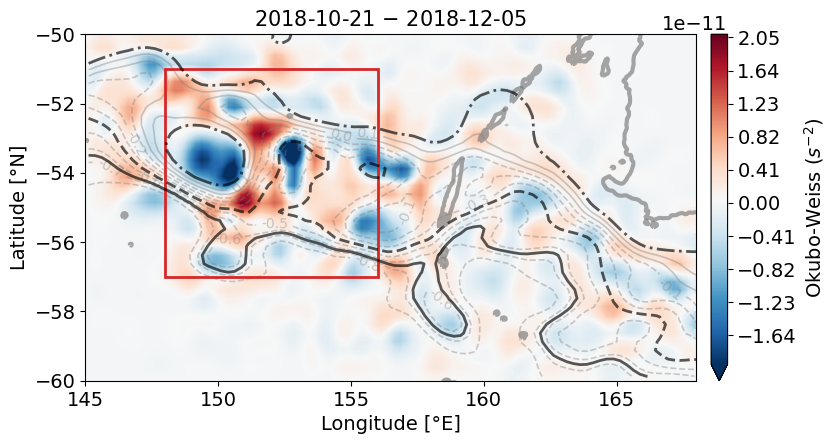

In [53]:
ow_grad = calc.sshGrad(ow)
# vmin, vmax = 0, 1e-15
vmin, vmax = -2e-11, 2e-11


fig, ax = plt.subplots(figsize = (9.5,4.5))
mean_ow = ow.sel(time = slice(start_time, end_time)).mean(dim = 'time').sel(longitude = slice(lonmin, lonmax))
mean_ow.plot(cmap = 'RdBu_r', levels = np.arange(vmin, vmax+1e-12, 1e-13), add_colorbar = False)
mean_ow.plot.contourf(cmap = 'RdBu_r', levels = np.arange(vmin, vmax+1e-12, 1e-13), #vmin = vmin, vmax = vmax,
                            cbar_kwargs = dict(label = 'Okubo-Weiss ($s^{-2}$)', pad = 0.02))

CS = msl.plot.contour(colors = 'grey', linewidths = 1.2, alpha = 0.4, levels = ssh_levels, zorder = 1)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.1f')

CS = new_bathy.depth.plot.contour(colors = 'grey', linewidths = 3, levels = d_levels, alpha = 0.7)

# PF
msl.plot.contour(levels = np.arange(-0.65, -0.64, 0.05), linestyles = '-',
                                         colors = 'k', alpha = 0.65, linewidths = 2, zorder = 5)

# SAF-S
msl.plot.contour(levels = np.arange(-0.4, -0.39, 0.05), linestyles = '--',
                                         colors = 'k', alpha = 0.65, linewidths = 2, zorder = 5) 

# SAF-N
msl.plot.contour(levels = np.arange(0.21, 0.22, 0.05), linestyles = '-.',
                                         colors = 'k', alpha = 0.65, linewidths = 2, zorder = 5) 


rect = mpatches.Rectangle((blonmin,blatmin),blonmax-blonmin,blatmax-blatmin, edgecolor='tab:red', facecolor="none", linewidth =2, 
                         zorder = 4)

plt.gca().add_patch(rect)


ax.set_ylim(latmin, latmax)
ax.set_xlim(lonmin, lonmax)
ax.set_xlabel(u'Longitude [\N{DEGREE SIGN}E]')
ax.set_ylabel(u'Latitude [\N{DEGREE SIGN}N]')
plt.title(f'{start_time} $-$ {end_time}', fontsize = 15)

In [54]:
# settings.save_figure(fig, my_path, 'OW.png', dpi = 600, pad = None)

In [57]:
# var = sst_gradient
# vmin, vmax = 0, 1.5e-4
lons = slice(148,155)
# lats = slice(-51,-56)
# cmap = 'viridis'
# label = u'SST gradient (\N{DEGREE SIGN}C)'
# extend = 'max'
# latmin, latmax = -51, -56

# var = sst_deg
# label = 'SST (\N{DEGREE SIGN}C)'
# cmap = 'plasma'
# vmin, vmax = 0, 9
# extend = 'both'
# lats = slice(-51,-56)
# latmin, latmax = -51, -56

var = ow
vmin, vmax = -3e-11, 3e-11
# var = qgvb.normal_strain
# vmin, vmax = -3e-6, 3e-6
lats = slice(-56,-52)
cmap = 'RdBu_r'
label = u'Okubo-Weiss'
extend = 'both'
latmin, latmax = -56, -51

# var = qgvb.divag
# vmin, vmax = -6e-8, 6e-8
# cmap = 'PuOr'
# label = u'divergence ($s^{-1}$)'
# label = r'$\frac{\delta ua}{\delta x}$ + $\frac{\delta va}{\delta y}$'
# extend = 'both'

# ageos = gradvel.Vgrad - gradvel.Vgeos
# ageos_ratio = ageos/gradvel.Vgrad
# var = ageos
# label = r'${u_a}$ ($m$ $s^{-1}$)'
# cmap = 'RdBu_r'
# vmin, vmax = -0.007, 0.007
# extend = 'both'

# var = qgvb.zeta
# vmin, vmax = -6e-6, 6e-6
# cmap = 'RdBu_r'
# label = u'relative vorticity'
# # label = r'$\frac{\delta v}{\delta x}$ - $\frac{\delta u}{\delta y}$'
# extend = 'both'

# var = fsle
# vmin, vmax = -0.45, 0
# cmap = 'RdYlBu'
# label = u'FSLE ($day^{-1}$)'
# extend = 'min'
# latmin, latmax = -56, -51

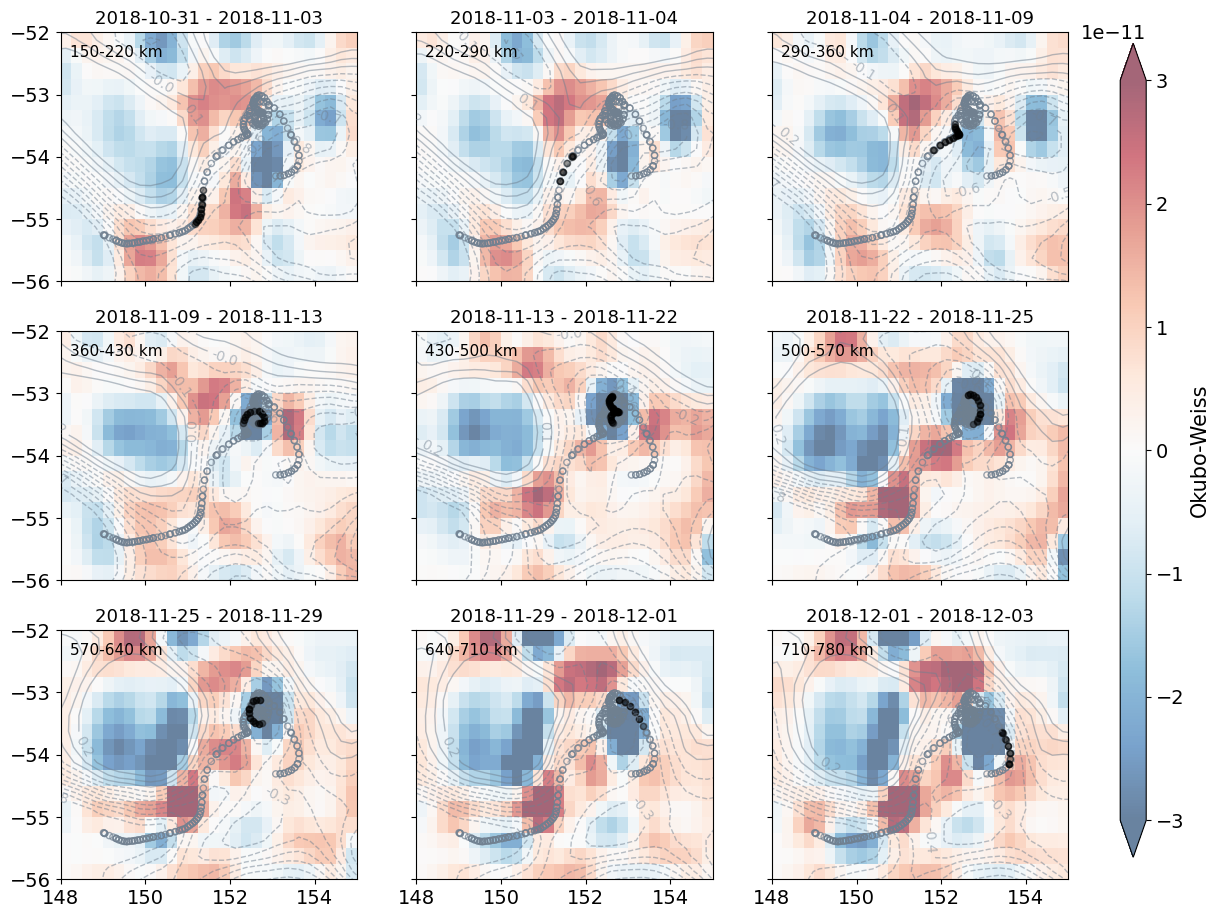

In [58]:
fig, axs = plt.subplots(nrows = 3, ncols=3, sharey = True, sharex = True, figsize = (13,11))
axs = axs.flatten()

d1 = 150
interval = 70 #in km along track

i = 0
for t in range(d1, d1 + interval*len(axs), interval):
    
    i_1 = stats.find_nearest(dist, t)[0]
    i_2 = stats.find_nearest(dist, t + interval)[0]
    
    start = float_num.time[i_1].values
    end = float_num.time[i_2].values
    start_time, end_time = str(start.astype('M8[D]')),  str(end.astype('M8[D]'))
    
    mean_field = var.sel(time = slice(start_time, end_time), 
                         latitude = lats, longitude = lons).mean(dim = 'time')
    
    im = mean_field.plot(ax = axs[i], alpha = 0.6, cmap = cmap, vmin = vmin, vmax = vmax, add_colorbar = False)
    
    levels = np.arange(-0.8,0.3,0.1)
    msl = alt_cmems.adt.sel(time = slice(start_time, end_time)).mean(dim = 'time')
    CS = msl.plot.contour(ax = axs[i], colors = 'slategrey', linewidths = 1, levels = levels, alpha = 0.5)
    plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.1f')
    
    # ageostrophic vel vectors
    if label == r'${u_a}$ ($m$ $s^{-1}$)':
        ua = gradvel.ugrad - gradvel.ugeos
        va = gradvel.vgrad - gradvel.vgeos
        ua_mean = ua.sel(time = slice(start_time, end_time), latitude = lats, longitude = lons).mean(dim = 'time')
        va_mean = va.sel(time = slice(start_time, end_time), latitude = lats, longitude = lons).mean(dim = 'time')
        axs[i].quiver(mean_field.longitude,  mean_field.latitude, ua_mean, va_mean, scale = 0.2, alpha = 0.7,  width = 0.004)
    
    axs[i].scatter(float_num.longitude[rs], float_num.latitude[rs], s = 20, facecolors='none', edgecolors='slategrey', alpha = 0.7, zorder = 3)
    axs[i].scatter(float_num.longitude[i_1:i_2], float_num.latitude[i_1:i_2], s = 20, c = 'k', alpha = 0.4, zorder = 3)
    
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_title(start_time + ' - ' + end_time, fontsize = 13)
    axs[i].text(0.03, 0.9, f'{t}-{t+interval} km', transform = axs[i].transAxes, fontsize = 11, c = 'k')
    
    i += 1
    
cax = plt.axes([0.94, 0.13, 0.02, 0.74])
cbar = plt.colorbar(im, cax=cax, extend = extend)
cbar.set_label(label, fontsize = 15)


In [63]:
var = sst_deg
label = 'SST (\N{DEGREE SIGN}C)'
cmap = 'plasma'
vmin, vmax = 0, 9
extend = 'both'
lats = slice(-51,-56)
latmin, latmax = -51, -56

Text(0, 0.5, 'Latitude [°N]')

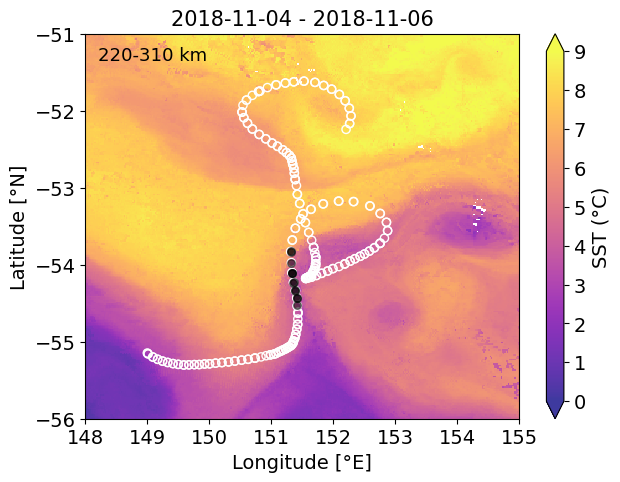

In [64]:
floatid = 8492
float_num = ema[floatid]
dist = calc.cum_dist(float_num.longitude, float_num.latitude)
rs = calc.findRSperiod(float_num)

d1, d2 = 220, 310
i_1 = stats.find_nearest(dist, d1)[0]
i_2 = stats.find_nearest(dist, d2)[0]

start = float_num.time[i_1].values
end = float_num.time[i_2].values

start_time, end_time = str(start.astype('M8[D]')),  str(end.astype('M8[D]'))
mean_var = var.sel(time = slice(start_time, end_time)).mean(dim = 'time', skipna = True)

levels = np.arange(-0.8,0.4,0.1)
msl = alt_cmems.adt.sel(time = slice(start_time, end_time)).mean(dim = 'time')


fig, ax = plt.subplots(figsize = (7,5))
mean_var.sel(latitude = slice(latmin, latmax), longitude = slice(148,155)).plot(vmin = vmin, vmax = vmax, alpha = 0.8, 
                                                                         cmap = cmap, extend = extend,
                                                                        cbar_kwargs = dict(label = label))

# CS = msl.plot.contour(colors = 'k', linewidths = 1.2, levels = levels, alpha = 0.4, zorder = 4)
# plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.1f')

# plt.scatter(float_num.longitude, float_num.latitude, s = 35, facecolors='grey', edgecolors='w', zorder = 4)
plt.scatter(float_num.longitude[rs], float_num.latitude[rs], s = 35, facecolors='none', edgecolors='w', zorder = 4)
plt.scatter(float_num.longitude[i_1:i_2], float_num.latitude[i_1:i_2], s = 30, facecolors='k', alpha = 0.5, zorder = 4)

# ax.set_title(r'$\bf{EM-8493}$'+ '\n' + start_time + ' - ' + end_time, fontsize = 15)
ax.set_title(start_time + ' - ' + end_time, fontsize = 15)
ax.text(0.03, 0.93, f'{d1}-{d2} km', transform = ax.transAxes, fontsize = 13, zorder = 5)

ax.set_xlabel(u'Longitude [\N{DEGREE SIGN}E]')
ax.set_ylabel(u'Latitude [\N{DEGREE SIGN}N]')


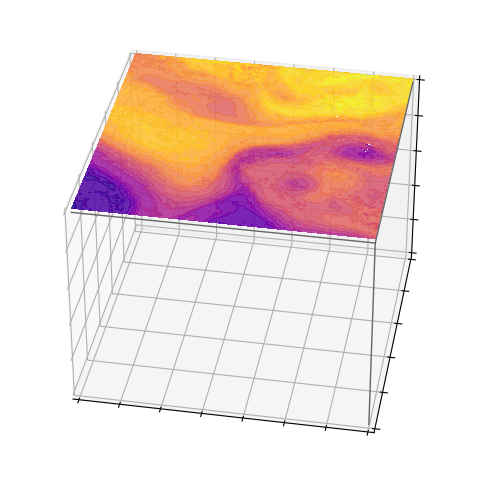

In [65]:
from mpl_toolkits.mplot3d import Axes3D
c = mean_var.sel(latitude = slice(latmin, latmax), longitude = slice(148,155))
x,y = np.meshgrid(c.longitude.data,c.latitude.data)

xmin, xmax = 148,155
ymin, ymax = -56,-51
zmin, zmax = 1000, 0

fig = plt.figure(figsize=(6,7))
ax = fig.add_subplot(projection='3d')

ax.contourf(x, y, c.data, offset = -20, zdir='z', levels = np.arange(0,10, 0.5), cmap = 'plasma', alpha = 0.85)
ax.contourf(x, y, c.data, offset = -20, zdir='y', levels = np.arange(0,10, 0.5), cmap = 'plasma', alpha = 0.85)
ax.set(xlim = (xmin, xmax), ylim = (ymin, ymax), zlim = (zmin, zmax))
ax.view_init(35, 280)

ax.set_xticklabels('')
# ax.set_zlabel('z')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
ax.set_yticklabels('')
ax.set_zticklabels('')

edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
# ax.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], **edges_kw)

In [73]:
# settings.save_figure(fig, my_path, '3D_map.png', dpi = 300, pad = 0.2)

### Interpolated onto the float tracks

In [66]:
# var = fsle
# label = 'FSLE ($day^{-1}$)'
# ymin, ymax = -1, 0
# c = 'tab:red'

var = ow
# var = ow_grad
# ymin, ymax = 0, 1e-15
ymin, ymax = -4.8e-11, 4.8e-11
label = 'Okubo-Weiss ($s^{-2}$)'
c = 'tab:blue'

# var = mean_EKE
# ymin, ymax = 0, 0.3
# c = 'tab:orange'
# label = '$\overline{EKE}$ ($m^{2}$ $s^{-2}$)'

In [72]:
floatids = [8489, 8490, 8492, 8493]

to_flt = {}

for floatid in floatids: 
    float_num = ema[floatid]
    rs = calc.findRSperiod(float_num)
    dist = calc.cum_dist(float_num.longitude, float_num.latitude)
    
    interp_val = interp.interpToFloat(float_num, var)[rs]
#     interp_val, lower, upper = stats.temporalError(float_num, var, method = 'interp', rs = True, location_only = True)
    to_flt[floatid] = xr.DataArray(interp_val.data, dims = 'distance', coords = dict(distance = ('distance', dist[rs].data)))
    

In [73]:
data_concat = ct.joinFloats(to_flt, 'distance', new_dim = True)
ticks, values, flt_dist_loc = plots.concatTickValues(to_flt)

Text(0.86, 1.02, 'EM-8493')

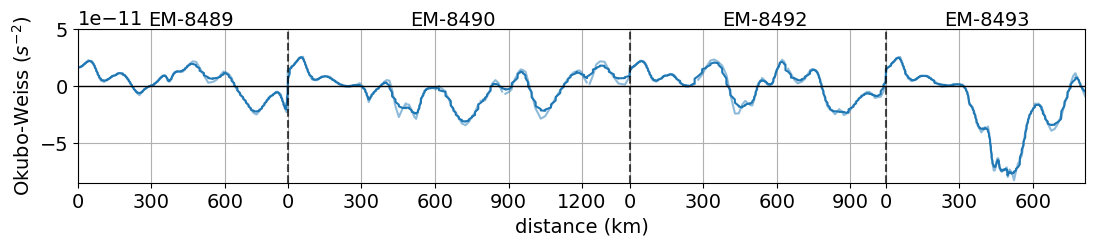

In [74]:
fig, ax = plt.subplots(figsize = (13,2))
data_concat.plot(c = c, alpha = 0.5)
data_concat.rolling(distance = 9, center = True, min_periods = 5).mean().plot(c = c)

ax.axhline(y = 0, c = 'k',  linewidth = 1)

for i in range(0,len(flt_dist_loc)):
    ax.axvline(x = flt_dist_loc[i], linestyle = '--', color = 'k', alpha = 0.7)
    
ax.set_xticks(ticks)
ax.set_xticklabels(values)
ax.set_ylim(-8.5e-11,5e-11)
ax.set_ylabel(label)
ax.grid()
ax.set_xlim(0, data_concat.distance[-1])
plt.xlabel('distance (km)')

ax.text(0.07, 1.02, 'EM-8489', transform = ax.transAxes)
ax.text(0.33, 1.02, 'EM-8490', transform = ax.transAxes)
ax.text(0.64, 1.02, 'EM-8492', transform = ax.transAxes)
ax.text(0.86, 1.02, 'EM-8493', transform = ax.transAxes)